In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
pd.options.display.float_format = '{:,.2f}'.format # формат вывода чисел с плавающей точкой

# Разведывательный анализ данных

## Часть 0. Используемые функции и процедуры

In [2]:
# Функция percentage строит датафрейм, показывающий распределение параметра key_field в заисимости от изменения параметра obj.
# Строки датафрейма: значения или группы значений параметра obj.
# Поля датафрейма: количество значений параметра key_field в абсолютном и процентном виде,
# а также количество строк с отсутствующимb значениями параметра key_field.
def percentage (df, key_field, obj, to_display=False):

    # Обработка ошибок
    if (obj not in df.columns) or (key_field not in df.columns):
        print ('Error: there no such column in dataset')
        return None
    
    cond = df[key_field].isna()  
    
    if len(df[cond]) == 0:
        print ('There are no NaN to replace')
        return None
        
    # Для поля 'score' делаем отдельный от других полей индекс для использования в параметре bins в value_counts   
    if obj == 'score': scale = [0,25,50,75,100]
    else: scale = None
        
    # Определяем количество уникальных признаков в key_field и second_obj
    x = len(df[key_field].value_counts())
    
    # Формируем двухуровневый список полей итогового датафрейма
    
    # Формируем первый уровень заголовков
    level_1 = ['with_data'] * (x+1)
    level_1.extend(['%']*x)
    level_1.extend(['without_data'])
    level_1.extend(['to_fill']*x)
    
    # Формируем второй уровень заголовков
    field_list = df[key_field].value_counts().index.tolist()
    level_2 = field_list + ['all'] + field_list + [''] + field_list

    # Формируем индекс итогового датафрейма и создаем датафрейм
    my_index = df[obj].value_counts(bins=scale).index.tolist()
    a = pd.DataFrame(index = my_index, columns = [level_1, level_2])
    a.sort_index (inplace=True)
    
    a['with_data','all'] = df[obj][~cond].value_counts(bins=scale) # Заполняем поле obj, исключая отсутствующие данные в key_field
    a['without_data',''] = df[obj][ cond].value_counts(bins=scale) # Заполняем поле obj из строк, где нет данных по полю key_field
    a['temp'] = 0

    for i in range(x):
        a['with_data',level_2[i]] = df[obj][(~cond) & (df[key_field] == level_2[i])].value_counts(bins=scale)
        a['%'        ,level_2[i]] = a['with_data',level_2[i]] / a['with_data','all'] * 100
        if i<x-1:
            a['to_fill',level_2[i]] = round(a['without_data',''] * a['%',level_2[i]] / 100,0)
            a['temp'] += a['to_fill',level_2[i]]    
        else:
            a['to_fill',level_2[i]] = a['without_data',''] - a['temp']
        a['to_fill',level_2[i]] = a['to_fill',level_2[i]].apply(lambda x: int(x))
    a.drop(['temp'], axis = 1, level = 0, inplace = True)

    if to_display:
        print ('Анализ поля: ',key_field)
        display(a[['with_data']].sum(), a[['without_data']].sum(), a[['to_fill']].sum())
        display (a)
    return a


# Функция out_ranges ищет вылеты из допустимого диапазона для каждого поля датафрейма без учета пропущенных значений.
# Если такие вылеты находятся функция выводит соответствующие строки датафрейма.
# Допустимые значения для каждого поля определены в описании датафрейма, либо взяты из фактических значений
# (например, абсолютное большинство строк в поле school имеют либо значение GP, либо значение MS;
# cоответственно, именно эти значения и будут допустимым интервалом).
def out_ranges():
    flag = False
    for col in stud.columns:
        condition = (~stud[col].isin(threshold[col])) & (~stud[col].isna())
        if len(stud[condition]) != 0:
            print ('\nВылеты по полю ',col,':',sep='')
            display (stud[condition])
            flag = True
    if not flag: print ('Вылетов за устновленные границы диапазонов нет')
    return 0


# Служебная функция make_conditions формирует список условий для группировки значений исследуемого признака
# при изменении значений по полю obj
def make_conditions (df, obj, cond):
    if obj == 'score':
        cond1 = (cond) & (df[obj] <= 25)
        cond2 = (cond) & (df[obj] > 25) & (df[obj] <= 50)
        cond3 = (cond) & (df[obj] > 50) & (df[obj] <= 75)
        cond4 = (cond) & (df[obj] > 75) & (df[obj] <= 100)
        all_cond = [cond1, cond2, cond3, cond4]
        return all_cond
    
    names = df[obj].value_counts().index.tolist()
    all_cond = [((cond) & (df[obj] == c)) for c in names]
    return all_cond


# Функция good_values осуществляет выборку строк с пропущенными значениями исследуемого признака и заполняет пропуски
# на основе распределения имеющихся значений
def good_values (df, key_field, obj, allocation):

    # Формирование условий отбора - получаем список условий
    conditions = make_conditions (df, obj, df[key_field].isna())
    
    # Получаем список уникальных значений исследуемого признка
    buscets = df[key_field].value_counts().index.tolist()
    
    # Задаем стартовые значения
    start = 0
    result= df.iloc[0:0]
    
    # Формируем датасет result как выборку строк исходного датасета на основе распределения allocation
    for bin_count, bin_name in enumerate(buscets):
        selection = df.iloc[0:0]
    
        for cond_count, cond in enumerate(conditions):
            stop  = int(allocation.iloc[cond_count]['to_fill',bin_name]) + start
            selection = pd.concat([selection, stud[cond].iloc[start:stop]])
        
        selection[key_field].fillna(bin_name, inplace = True)

        start += int(allocation.iloc[cond_count]['to_fill',bin_name])
        result = pd.concat([result,selection])
    return result


# Функция fill_values добавляет в исходный датасет заполненные пропуски и удаляет строки с пропусками 
def fill_values (df, key_field, obj='score', stat=0):

    s = percentage (df, key_field, obj, to_display=stat)
    if s is None:
        return df
    
    r = good_values(df, key_field, obj, s)
    df = pd.concat([df,r])
    df = df[~df[key_field].isna()]
    return df


# Функция get_stst проводит тест Стьюдента и выводит бокс-плоты для номинативных  переменных
def get_stat(column):
    fig, ax = plt.subplots()
    sns.boxplot(x=column, y='score', data=stud, ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
    cols = stud[column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

## Часть 1. Импорт и первый взгляд на данные

In [3]:
# Открываем файл, смотрим описание полей датасета
stud = pd.read_csv('stud_math.csv')
stud.info()
display(stud.describe())
nan_values = stud[stud.columns].apply(lambda x: x.isna().sum())
display (nan_values)
print ('Всего отсутствуюет ',nan_values.sum(), ' значений.')
stud.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.00,392.00,371.00,367.00,388.00,373.00,388.00,368.00,384.00,387.00,380.00,383.00,389.00
mean,16.70,2.75,2.61,1.44,2.04,0.34,-6.12,3.94,3.23,3.11,3.53,7.28,52.26
std,1.28,1.10,2.23,0.69,0.84,0.74,2.53,0.93,0.99,1.12,1.40,23.47,22.92
min,15.00,0.00,0.00,1.00,1.00,0.00,-12.00,-1.00,1.00,1.00,1.00,0.00,0.00
25%,16.00,2.00,2.00,1.00,1.00,0.00,-6.00,4.00,3.00,2.00,3.00,0.00,40.00
50%,17.00,3.00,2.00,1.00,2.00,0.00,-6.00,4.00,3.00,3.00,4.00,4.00,55.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,-3.00,5.00,4.00,4.00,5.00,8.00,70.00
max,22.00,4.00,40.00,4.00,4.00,3.00,-3.00,5.00,5.00,5.00,5.00,385.00,100.00


school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Всего отсутствуюет  565  значений.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
320,GP,F,17,U,GT3,A,4.00,3.00,services,services,course,mother,1.00,2.00,nan,no,yes,yes,no,yes,-6.00,NaN,yes,yes,5.00,2.00,2.00,5.00,23.00,65.00
284,GP,F,17,U,GT3,T,2.00,2.00,other,other,course,mother,1.00,2.00,0.00,no,yes,no,no,no,-6.00,yes,yes,no,5.00,4.00,5.00,5.00,4.00,55.00
280,GP,M,17,U,NaN,A,4.00,nan,services,other,home,mother,2.00,1.00,nan,no,no,yes,yes,yes,-3.00,yes,yes,NaN,4.00,nan,4.00,5.00,30.00,40.00
331,GP,F,17,R,GT3,T,2.00,4.00,at_home,other,course,NaN,1.00,3.00,0.00,no,yes,no,no,yes,-9.00,NaN,yes,yes,4.00,4.00,3.00,5.00,7.00,70.00
63,GP,F,16,U,GT3,NaN,4.00,3.00,teacher,health,NaN,mother,1.00,3.00,0.00,yes,yes,yes,yes,yes,-9.00,yes,yes,no,3.00,4.00,4.00,4.00,2.00,45.00
76,GP,M,15,U,NaN,T,4.00,0.00,teacher,other,course,mother,2.00,4.00,0.00,no,no,no,yes,yes,-12.00,NaN,yes,no,3.00,4.00,3.00,1.00,8.00,50.00
73,GP,M,16,U,GT3,T,3.00,1.00,other,other,NaN,mother,1.00,1.00,0.00,no,no,no,yes,yes,-3.00,yes,no,no,nan,3.00,2.00,5.00,2.00,70.00


### Выводы по первому взгляду на данные:
1. Датасет небольшой: 395 строк.
2. Относительно большой объем отсутствующих данных: по некоторым полям (pstatus, paid) свыше 10%.
3. Датасет содержит 14 полей цифрового типа. Обратим на них повышенное внимание при обработке, будем смотреть распределение и выбросы.
3. Поле 'studytime, granular' не содержится в описании датасета - удаляем.
4. Ключевое поле (score) сожержит 6 пропусков - заполнять их бессмысленно т.к. это поле - итоговое для работы модели. Заполнение пропусков по средней, либо по наиболее частому значению может привкести к искажению результатов анализа. Удаляем. 
5. Первые три поля (school, sex, age) не содержат ошибок - постараемся использовать для заполнения пропусков в других полях.
6. Поле score будем далее использовать как важный классификатор при заполнении отсутствующих данных и модель для контроля количество записей (строк) в датасете

In [4]:
# Удаляем 'studytime, granular'
stud.drop(['studytime, granular'], axis=1, inplace=True)

### Проверим данные на выбросы за рамки здравого смысла
Создадим справочник допустимых значений по каждому из полей датафрейма на основе описания 

In [5]:
threshold = {
    'school': ['GP', 'MS'],
    'sex': ['F', 'M'],
    'age': range(15,23),
    'address': ['R', 'U'],
    'famsize': ['GT3', 'LE3'],
    'Pstatus': ['T', 'A'],
    'Medu': range(0,5),
    'Fedu': range(0,5),
    'Mjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'Fjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'reason':['home', 'reputation', 'course', 'other'],
    'guardian': ['mother', 'father', 'other'],
    'traveltime': range(1,5),
    'studytime': range(1,5),
    'failures': range(0,4),
    'schoolsup': ['yes','no'],
    'famsup': ['yes','no'],
    'paid': ['yes','no'],
    'activities': ['yes','no'],
    'nursery': ['yes','no'],
    'higher': ['yes','no'],
    'internet': ['yes','no'],
    'romantic': ['yes','no'],
    'famrel': range(1,6),
    'freetime': range(1,6),
    'goout': range(1,6),
    'health': range(1,6),
    'absences': range (0,191),
# принимаем продолжительность учебногогода в 38-39 недель; пропусков не может быть больше
# https://www.estudy.ru/important-to-know/articles/view/42-shkolnyi-god-uchebnyi-den-v-shkole-v-velikobritanii.htm
    'score': range(0,101)}

Проверим датафрейм на выбросы за рамки установленных шкал (пока без учета незаполненных значений)

In [6]:
out_ranges()


Вылеты по полю Fedu:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.00,40.00,services,other,reputation,father,3.00,3.00,0.00,no,yes,no,yes,yes,yes,yes,no,5.00,2.00,2.00,4.00,4.00,60.00



Вылеты по полю famrel:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.00,2.00,services,services,home,mother,1.00,1.00,2.00,no,yes,yes,no,no,yes,yes,no,-1.00,2.00,2.00,5.00,14.00,40.00



Вылеты по полю absences:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.00,3.00,services,teacher,other,mother,1.00,2.00,0.00,yes,NaN,no,no,yes,yes,yes,no,2.00,3.00,1.00,3.00,385.00,85.00
390,MS,M,20,U,LE3,A,2.00,2.00,services,services,course,NaN,1.00,2.00,2.00,no,yes,yes,no,yes,yes,no,no,5.00,5.00,4.00,4.00,212.00,45.00


0

1. Вылет по полю fedu: 40. Допустимый диапазон: от 0 до 4. Очевидно, это опечатка, необходимо заменить на 4. <br>
2. Вылет по полю famrel: -1. Допустимый диапазон: от 1 до 5. Возможно, опечатка; меняем на 1. <br>
3. Два вылета по полю absences: 385 и 212. В качестве допустимого диапазона принят интервал от 0 до 190: максимальное количество учебных дней исходя из 38 учебных недель. Удаляем эти значения, оставляя пропуски (NaN).

In [7]:
stud['Fedu'] = np.where(stud['Fedu'] == 40, 4, stud['Fedu'])
stud['famrel'] = np.where(stud['famrel'] == -1, 1, stud['famrel'])
stud['absences'] = np.where(stud['absences'] == 385, np.nan, stud['absences'])
stud['absences'] = np.where(stud['absences'] == 212, np.nan, stud['absences'])

In [8]:
# Проверяем, что получилось:
out_ranges ()

Вылетов за устновленные границы диапазонов нет


0

## Часть 2. Заполнение пропущенных данных

Большинство полей кроме трех исключений заполним на основании распределения имеющихся данных по этим полям (без пропусков) по 4-м группам итоговых баллов: 0-25, 26-50, 51-75, 76-100.
### Исключнения:
1. Пропуски по полю 'score' заполнять не будем, так как это итоговое поле для будущей модели. 
2. Здравый смысл подсказывает, что поле 'address' может зависить от поля 'school'. //Проверить через корр. анализ// Поэтому, пропуски в поле 'address' заполним на основании распределения по полю 'school'.
2. Поле 'absences' заполним по медиане выборки, состоящей из 80% наиболее частовстречающихся значений

### Исключение 1. Обработка поля score

In [9]:
# Ключевое поле - score - содержит 389 цифровых значений из 395. Смотрим на 6 отсавшихся строк: 
stud[stud['score'].isna()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2.00,3.00,other,other,reputation,mother,1.00,2.00,0.00,yes,yes,NaN,yes,yes,yes,no,no,4.00,nan,3.00,4.00,6.00,nan
244,GP,F,18,U,GT3,T,2.00,1.00,other,other,course,other,2.00,3.00,0.00,no,yes,yes,no,no,yes,yes,yes,4.00,4.00,4.00,3.00,0.00,nan
270,GP,F,19,NaN,GT3,T,3.00,3.00,other,services,home,other,1.00,2.00,2.00,no,yes,yes,yes,yes,yes,yes,no,4.00,3.00,5.00,5.00,nan,nan
283,GP,F,18,U,GT3,T,1.00,1.00,other,other,home,mother,2.00,2.00,0.00,yes,NaN,no,yes,yes,yes,yes,no,5.00,nan,4.00,4.00,4.00,nan
312,GP,M,19,U,GT3,T,1.00,2.00,other,services,course,other,1.00,2.00,1.00,no,no,no,no,no,yes,yes,no,4.00,5.00,nan,4.00,3.00,nan
350,MS,M,19,NaN,GT3,T,1.00,1.00,other,services,home,other,3.00,2.00,3.00,no,no,no,no,NaN,yes,yes,no,5.00,4.00,4.00,2.00,8.00,nan


In [10]:
# Удаляем строки с NaN в поле score
field = 'score'
condition = stud[field].isna()
stud = stud[~condition]

In [11]:
# Проверяем, что получилось
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  score : 0. Записей в датасете: 389


(80.0, 100.0]    0.06
(-0.101, 20.0]   0.10
(20.0, 40.0]     0.16
(60.0, 80.0]     0.28
(40.0, 60.0]     0.41
Name: score, dtype: float64

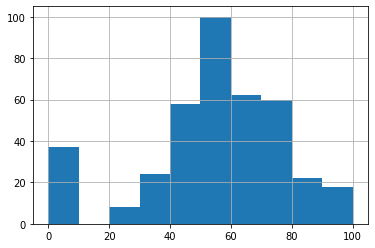

In [12]:
# Посмотрим на распределение значений в поле 'score'
stud['score'].hist()
stud['score'].value_counts(bins=5, normalize=True, ascending=True)

Обращаем внимание на нормальное распределение признака за исключением нескольких нулевых значений. Наибольшее количество значений укладывается в диапазон от 40 до 80.

### Исключение 2.  Обработка поля address

In [13]:
# Посмотрим на рспределение адресов в заисимости от школы 
field = 'address'
s = percentage (stud, field, 'school', to_display=True)
s

Анализ поля:  address


with_data  U      291
           R       83
           all    374
dtype: int64

without_data      15
dtype: int64

to_fill  U    11
         R     4
dtype: int64

with_data              %       without_data to_fill   
           U   R  all     U     R                    U  R
GP       273  60  333 81.98 18.02           11       9  2
MS        18  23   41 43.90 56.10            4       2  2

with_data              %       without_data to_fill   
           U   R  all     U     R                    U  R
GP       273  60  333 81.98 18.02           11       9  2
MS        18  23   41 43.90 56.10            4       2  2

Основная часть студентов школы GP (82%) живет в городе (U), тогда как в школе MS
адреса студентов распределены примерно поровну.

In [14]:
# Поле адрес заполняем на основе изменений по полю school 
field = 'address'
stud = fill_values (stud, field, obj='school', stat=0)

In [15]:
condition = stud[field].isna()
stud = stud[~condition]

In [16]:
# Проверяем, что получилось
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  address : 0. Записей в датасете: 389


### Исключение 3.  Обработка поля absences

In [17]:
field = 'absences'
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  absences : 13. Записей в датасете: 389


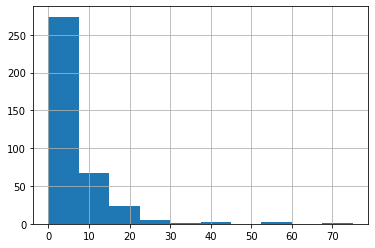

In [18]:
stud[field].hist()

Видно, что большинство пропусков не превышает 20

In [19]:
low_absences = stud[((stud[field].isna()) | (stud[field] <= 20))]
stud['absences'].fillna(low_absences['absences'].median(), inplace=True)
stud['absences'].isna().sum()

0

### Обработка всех прочих полей

In [20]:
# Вызываем процедуру заполнения пропусков для всех полей, кроме тех, где пропусков уже нет 
for col in stud.columns[4:27]:
    stud = fill_values (stud, col, stat=1)

Анализ поля:  famsize


with_data  GT3    255
           LE3    107
           all    362
dtype: int64

without_data      27
dtype: int64

to_fill  GT3    19
         LE3     8
dtype: int64

with_data              %       without_data to_fill    
                     GT3 LE3  all   GT3   LE3                  GT3 LE3
(-0.001, 25.0]        33   8   41 80.49 19.51            4       3   1
(25.0, 50.0]          85  40  125 68.00 32.00           13       9   4
(50.0, 75.0]         114  46  160 71.25 28.75            6       4   2
(75.0, 100.0]         23  13   36 63.89 36.11            4       3   1

Анализ поля:  Pstatus


with_data  T      309
           A       35
           all    344
dtype: int64

without_data      45
dtype: int64

to_fill  T    41
         A     4
dtype: int64

with_data              %       without_data to_fill   
                       T   A  all     T     A                    T  A
(-0.001, 25.0]        39   2   41 95.12  4.88            4       4  0
(25.0, 50.0]         112  12  124 90.32  9.68           14      13  1
(50.0, 75.0]         128  16  144 88.89 11.11           22      20  2
(75.0, 100.0]         30   5   35 85.71 14.29            5       4  1

Анализ поля:  Medu


with_data  4.0    131
           2.0     99
           3.0     95
           1.0     57
           0.0      3
           all    385
dtype: int64

without_data      4
dtype: int64

to_fill  4.00    1
         2.00    1
         3.00    1
         1.00    1
         0.00    0
dtype: int64

with_data                          %                         \
                     4.0 2.0 3.0 1.0 0.0  all   4.0   2.0   3.0   1.0  0.0   
(-0.001, 25.0]         9  12  12  11   0   44 20.45 27.27 27.27 25.00 0.00   
(25.0, 50.0]          38  35  35  26   1  135 28.15 25.93 25.93 19.26 0.74   
(50.0, 75.0]          62  47  37  18   2  166 37.35 28.31 22.29 10.84 1.20   
(75.0, 100.0]         22   5  11   2   0   40 55.00 12.50 27.50  5.00 0.00   

               without_data to_fill                  
                                4.0 2.0 3.0 1.0 0.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              3       1   1   1   1  -1  
(50.0, 75.0]              0       0   0   0   0   0  
(75.0, 100.0]             0       0   0   0   0   0

Анализ поля:  Fedu


with_data  2.0    103
           3.0     93
           4.0     91
           1.0     80
           0.0      2
           all    369
dtype: int64

without_data      23
dtype: int64

to_fill  2.00    7
         3.00    5
         4.00    6
         1.00    4
         0.00    1
dtype: int64

with_data                          %                         \
                     2.0 3.0 4.0 1.0 0.0  all   2.0   3.0   4.0   1.0  0.0   
(-0.001, 25.0]        14   7  10  11   0   42 33.33 16.67 23.81 26.19 0.00   
(25.0, 50.0]          32  39  20  42   1  134 23.88 29.10 14.93 31.34 0.75   
(50.0, 75.0]          49  36  49  22   0  156 31.41 23.08 31.41 14.10 0.00   
(75.0, 100.0]          8  11  12   5   1   37 21.62 29.73 32.43 13.51 2.70   

               without_data to_fill                  
                                2.0 3.0 4.0 1.0 0.0  
(-0.001, 25.0]            3       1   0   1   1   0  
(25.0, 50.0]              7       2   2   1   2   0  
(50.0, 75.0]             10       3   2   3   1   1  
(75.0, 100.0]             3       1   1   1   0   0

Анализ поля:  Mjob


with_data  other       133
           services     90
           teacher      60
           at_home      58
           health       32
           all         373
dtype: int64

without_data      18
dtype: int64

to_fill  other       6
         services    5
         teacher     3
         at_home     2
         health      2
dtype: int64

with_data                                          %           \
                   other services teacher at_home health  all other services   
(-0.001, 25.0]        17        9       4      10      2   42 40.48    21.43   
(25.0, 50.0]          49       25      25      28      8  135 36.30    18.52   
(50.0, 75.0]          61       42      22      18     17  160 38.12    26.25   
(75.0, 100.0]          6       14       9       2      5   36 16.67    38.89   

                                      without_data to_fill                   \
               teacher at_home health                other services teacher   
(-0.001, 25.0]    9.52   23.81   4.76            2       1        0       0   
(25.0, 50.0]     18.52   20.74   5.93            6       2        1       1   
(50.0, 75.0]     13.75   11.25  10.62            6       2        2       1   
(75.0, 100.0]    25.00    5.56  13.89            4       1        2       1   

                               
               at_home health  
(-0.001, 25.0]       0      1  
(25.0, 50.0]         1      1  
(50.0, 75.0]         1      0  
(75.0, 100.0]        0      0

Анализ поля:  Fjob


with_data  other       194
           services     99
           teacher      28
           health       17
           at_home      15
           all         353
dtype: int64

without_data      37
dtype: int64

to_fill  other       19
         services    10
         teacher      5
         health       2
         at_home      1
dtype: int64

with_data                                          %           \
                   other services teacher health at_home  all other services   
(-0.001, 25.0]        19       12       3      0       2   36 52.78    33.33   
(25.0, 50.0]          77       34       6      7       5  129 59.69    26.36   
(50.0, 75.0]          85       46      10      9       6  156 54.49    29.49   
(75.0, 100.0]         13        7       9      1       2   32 40.62    21.88   

                                      without_data to_fill                   \
               teacher health at_home                other services teacher   
(-0.001, 25.0]    8.33   0.00    5.56            7       4        2       1   
(25.0, 50.0]      4.65   5.43    3.88           12       7        3       1   
(50.0, 75.0]      6.41   5.77    3.85           10       5        3       1   
(75.0, 100.0]    28.12   3.12    6.25            8       3        2       2   

                               
               health at_home  
(-0.001, 25.0]      0       0  
(25.0, 50.0]        1       0  
(50.0, 75.0]        1       0  
(75.0, 100.0]       0       1

Анализ поля:  reason


with_data  course        138
           home          109
           reputation     98
           other          29
           all           374
dtype: int64

without_data      16
dtype: int64

to_fill  course        5
         home          4
         reputation    4
         other         3
dtype: int64

with_data                                 %                   \
                  course home reputation other  all course  home reputation   
(-0.001, 25.0]        19   12          7     2   40  47.50 30.00      17.50   
(25.0, 50.0]          51   41         34    11  137  37.23 29.93      24.82   
(50.0, 75.0]          54   46         46    12  158  34.18 29.11      29.11   
(75.0, 100.0]         14   10         11     4   39  35.90 25.64      28.21   

                     without_data to_fill                        
               other               course home reputation other  
(-0.001, 25.0]  5.00            3       1    1          1     0  
(25.0, 50.0]    8.03            4       1    1          1     1  
(50.0, 75.0]    7.59            8       3    2          2     1  
(75.0, 100.0]  10.26            1       0    0          0     1

Анализ поля:  guardian


with_data  mother    250
           father     88
           other      23
           all       361
dtype: int64

without_data      29
dtype: int64

to_fill  mother    20
         father     7
         other      2
dtype: int64

with_data                        %              without_data  \
                  mother father other  all mother father other                
(-0.001, 25.0]        29      9     3   41  70.73  21.95  7.32            2   
(25.0, 50.0]          86     32    11  129  66.67  24.81  8.53           12   
(50.0, 75.0]         107     37     7  151  70.86  24.50  4.64           15   
(75.0, 100.0]         28     10     2   40  70.00  25.00  5.00            0   

               to_fill               
                mother father other  
(-0.001, 25.0]       1      0     1  
(25.0, 50.0]         8      3     1  
(50.0, 75.0]        11      4     0  
(75.0, 100.0]        0      0     0

Анализ поля:  traveltime


with_data  1.0    242
           2.0     90
           3.0     22
           4.0     11
           all    365
dtype: int64

without_data      25
dtype: int64

to_fill  1.00    16
         2.00     7
         3.00     1
         4.00     1
dtype: int64

with_data                      %                  without_data  \
                     1.0 2.0 3.0 4.0  all   1.0   2.0   3.0  4.0                
(-0.001, 25.0]        24  11   4   0   39 61.54 28.21 10.26 0.00            4   
(25.0, 50.0]          83  36   8   8  135 61.48 26.67  5.93 5.93            6   
(50.0, 75.0]         108  34   9   3  154 70.13 22.08  5.84 1.95           12   
(75.0, 100.0]         27   9   1   0   37 72.97 24.32  2.70 0.00            3   

               to_fill              
                   1.0 2.0 3.0 4.0  
(-0.001, 25.0]       2   1   0   1  
(25.0, 50.0]         4   2   0   0  
(50.0, 75.0]         8   3   1   0  
(75.0, 100.0]        2   1   0   0

Анализ поля:  studytime


with_data  2.0    200
           1.0     99
           3.0     57
           4.0     29
           all    385
dtype: int64

without_data      5
dtype: int64

to_fill  2.00    3
         1.00    1
         3.00    0
         4.00    1
dtype: int64

with_data                      %                    \
                     2.0 1.0 3.0 4.0  all   2.0   1.0   3.0   4.0   
(-0.001, 25.0]        20  14   5   4   43 46.51 32.56 11.63  9.30   
(25.0, 50.0]          82  34  18   6  140 58.57 24.29 12.86  4.29   
(50.0, 75.0]          83  42  25  14  164 50.61 25.61 15.24  8.54   
(75.0, 100.0]         15   9   9   5   38 39.47 23.68 23.68 13.16   

               without_data to_fill              
                                2.0 1.0 3.0 4.0  
(-0.001, 25.0]            0       0   0   0   0  
(25.0, 50.0]              1       1   0   0   0  
(50.0, 75.0]              2       1   1   0   0  
(75.0, 100.0]             2       1   0   0   1

Анализ поля:  failures


with_data  0.0    297
           1.0     46
           3.0     15
           2.0     12
           all    370
dtype: int64

without_data      20
dtype: int64

to_fill  0.00    17
         1.00     3
         3.00     0
         2.00     0
dtype: int64

with_data                      %                  without_data  \
                     0.0 1.0 3.0 2.0  all   0.0   1.0   3.0  2.0                
(-0.001, 25.0]        21  11   5   4   41 51.22 26.83 12.20 9.76            2   
(25.0, 50.0]          97  23  10   6  136 71.32 16.91  7.35 4.41            5   
(50.0, 75.0]         144  11   0   2  157 91.72  7.01  0.00 1.27            9   
(75.0, 100.0]         35   1   0   0   36 97.22  2.78  0.00 0.00            4   

               to_fill              
                   0.0 1.0 3.0 2.0  
(-0.001, 25.0]       1   1   0   0  
(25.0, 50.0]         4   1   0   0  
(50.0, 75.0]         8   1   0   0  
(75.0, 100.0]        4   0   0   0

Анализ поля:  schoolsup


with_data  no     326
           yes     55
           all    381
dtype: int64

without_data      8
dtype: int64

to_fill  no     7
         yes    1
dtype: int64

with_data              %       without_data to_fill    
                      no yes  all    no   yes                   no yes
(-0.001, 25.0]        36   5   41 87.80 12.20            1       1   0
(25.0, 50.0]         106  32  138 76.81 23.19            3       2   1
(50.0, 75.0]         145  17  162 89.51 10.49            4       4   0
(75.0, 100.0]         39   1   40 97.50  2.50            0       0   0

Анализ поля:  famsup


with_data  yes    224
           no     127
           all    351
dtype: int64

without_data      38
dtype: int64

to_fill  yes    25
         no     13
dtype: int64

with_data              %       without_data to_fill   
                     yes  no  all   yes    no                  yes no
(-0.001, 25.0]        26  14   40 65.00 35.00            2       1  1
(25.0, 50.0]          84  44  128 65.62 34.38           13       9  4
(50.0, 75.0]          91  56  147 61.90 38.10           19      12  7
(75.0, 100.0]         23  13   36 63.89 36.11            4       3  1

Анализ поля:  paid


with_data  no     198
           yes    152
           all    350
dtype: int64

without_data      38
dtype: int64

to_fill  no     22
         yes    16
dtype: int64

with_data              %       without_data to_fill    
                      no yes  all    no   yes                   no yes
(-0.001, 25.0]        28   9   37 75.68 24.32            4       3   1
(25.0, 50.0]          67  58  125 53.60 46.40           16       9   7
(50.0, 75.0]          78  73  151 51.66 48.34           15       8   7
(75.0, 100.0]         25  12   37 67.57 32.43            3       2   1

Анализ поля:  activities


with_data  yes    190
           no     184
           all    374
dtype: int64

without_data      14
dtype: int64

to_fill  yes    7
         no     7
dtype: int64

with_data              %       without_data to_fill   
                     yes  no  all   yes    no                  yes no
(-0.001, 25.0]        18  19   37 48.65 51.35            4       2  2
(25.0, 50.0]          65  71  136 47.79 52.21            5       2  3
(50.0, 75.0]          86  75  161 53.42 46.58            5       3  2
(75.0, 100.0]         21  19   40 52.50 47.50            0       0  0

Анализ поля:  nursery


with_data  yes    303
           no      72
           all    375
dtype: int64

without_data      13
dtype: int64

to_fill  yes    11
         no      2
dtype: int64

with_data              %       without_data to_fill   
                     yes  no  all   yes    no                  yes no
(-0.001, 25.0]        31   8   39 79.49 20.51            2       2  0
(25.0, 50.0]         112  25  137 81.75 18.25            4       3  1
(50.0, 75.0]         127  35  162 78.40 21.60            4       3  1
(75.0, 100.0]         33   4   37 89.19 10.81            3       3  0

Анализ поля:  higher


with_data  yes    347
           no      18
           all    365
dtype: int64

without_data      23
dtype: int64

to_fill  yes    22
         no      1
dtype: int64

with_data              %       without_data to_fill   
                     yes no  all    yes    no                  yes no
(-0.001, 25.0]        36  4   40  90.00 10.00            1       1  0
(25.0, 50.0]         120  9  129  93.02  6.98           12      11  1
(50.0, 75.0]         152  5  157  96.82  3.18            9       9  0
(75.0, 100.0]         39  0   39 100.00  0.00            1       1  0

Анализ поля:  internet


with_data  yes    297
           no      59
           all    356
dtype: int64

without_data      32
dtype: int64

to_fill  yes    26
         no      6
dtype: int64

with_data              %       without_data to_fill   
                     yes  no  all   yes    no                  yes no
(-0.001, 25.0]        31   6   37 83.78 16.22            4       3  1
(25.0, 50.0]         109  23  132 82.58 17.42            9       7  2
(50.0, 75.0]         123  27  150 82.00 18.00           16      13  3
(75.0, 100.0]         34   3   37 91.89  8.11            3       3  0

Анализ поля:  romantic


with_data  no     245
           yes    117
           all    362
dtype: int64

without_data      26
dtype: int64

to_fill  no     18
         yes     8
dtype: int64

with_data              %       without_data to_fill    
                      no yes  all    no   yes                   no yes
(-0.001, 25.0]        22  17   39 56.41 43.59            2       1   1
(25.0, 50.0]          93  40  133 69.92 30.08            8       6   2
(50.0, 75.0]         100  51  151 66.23 33.77           15      10   5
(75.0, 100.0]         30   9   39 76.92 23.08            1       1   0

Анализ поля:  famrel


with_data  4.0    180
           5.0     84
           3.0     67
           2.0     19
           1.0      9
           all    359
dtype: int64

without_data      29
dtype: int64

to_fill  4.00    14
         5.00     6
         3.00     6
         2.00     2
         1.00     1
dtype: int64

with_data                          %                         \
                     4.0 5.0 3.0 2.0 1.0  all   4.0   5.0   3.0   2.0  1.0   
(-0.001, 25.0]        12  12   6   7   1   38 31.58 31.58 15.79 18.42 2.63   
(25.0, 50.0]          78  21  27   2   1  129 60.47 16.28 20.93  1.55 0.78   
(50.0, 75.0]          72  37  30   8   6  153 47.06 24.18 19.61  5.23 3.92   
(75.0, 100.0]         18  14   4   2   1   39 46.15 35.90 10.26  5.13 2.56   

               without_data to_fill                  
                                4.0 5.0 3.0 2.0 1.0  
(-0.001, 25.0]            3       1   1   0   1   0  
(25.0, 50.0]             12       7   2   3   0   0  
(50.0, 75.0]             13       6   3   3   1   0  
(75.0, 100.0]             1       0   0   0   0   1

Анализ поля:  freetime


with_data  3.0    155
           4.0    116
           2.0     62
           5.0     33
           1.0     16
           all    382
dtype: int64

without_data      6
dtype: int64

to_fill  3.00    2
         4.00    2
         2.00    1
         5.00    0
         1.00    1
dtype: int64

with_data                          %                         \
                     3.0 4.0 2.0 5.0 1.0  all   3.0   4.0   2.0   5.0  1.0   
(-0.001, 25.0]        19   9   7   3   2   40 47.50 22.50 17.50  7.50 5.00   
(25.0, 50.0]          62  44  16  10   9  141 43.97 31.21 11.35  7.09 6.38   
(50.0, 75.0]          63  53  31  13   3  163 38.65 32.52 19.02  7.98 1.84   
(75.0, 100.0]         11  10   8   7   2   38 28.95 26.32 21.05 18.42 5.26   

               without_data to_fill                  
                                3.0 4.0 2.0 5.0 1.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              0       0   0   0   0   0  
(50.0, 75.0]              3       1   1   1   0   0  
(75.0, 100.0]             2       1   1   0   0   0

Анализ поля:  goout


with_data  3.0    127
           2.0     89
           4.0     85
           5.0     49
           1.0     24
           all    374
dtype: int64

without_data      13
dtype: int64

to_fill  3.00    4
         2.00    2
         4.00    3
         5.00    1
         1.00    3
dtype: int64

with_data                          %                         \
                     3.0 2.0 4.0 5.0 1.0  all   3.0   2.0   4.0   5.0  1.0   
(-0.001, 25.0]         8  10   9   9   3   39 20.51 25.64 23.08 23.08 7.69   
(25.0, 50.0]          42  27  37  20   6  132 31.82 20.45 28.03 15.15 4.55   
(50.0, 75.0]          65  38  35  14  12  164 39.63 23.17 21.34  8.54 7.32   
(75.0, 100.0]         12  14   4   6   3   39 30.77 35.90 10.26 15.38 7.69   

               without_data to_fill                  
                                3.0 2.0 4.0 5.0 1.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              9       3   2   3   1   0  
(50.0, 75.0]              2       1   0   0   0   1  
(75.0, 100.0]             1       0   0   0   0   1

Анализ поля:  health


with_data  5.0    135
           3.0     96
           4.0     55
           1.0     47
           2.0     41
           all    374
dtype: int64

without_data      13
dtype: int64

to_fill  5.00    5
         3.00    4
         4.00    2
         1.00    2
         2.00    0
dtype: int64

with_data                          %                          \
                     5.0 3.0 4.0 1.0 2.0  all   5.0   3.0   4.0   1.0   2.0   
(-0.001, 25.0]        17   9   6   4   4   40 42.50 22.50 15.00 10.00 10.00   
(25.0, 50.0]          42  42  21  17  13  135 31.11 31.11 15.56 12.59  9.63   
(50.0, 75.0]          64  38  20  19  18  159 40.25 23.90 12.58 11.95 11.32   
(75.0, 100.0]         12   7   8   7   6   40 30.00 17.50 20.00 17.50 15.00   

               without_data to_fill                  
                                5.0 3.0 4.0 1.0 2.0  
(-0.001, 25.0]            0       0   0   0   0   0  
(25.0, 50.0]              6       2   2   1   1   0  
(50.0, 75.0]              7       3   2   1   1   0  
(75.0, 100.0]             0       0   0   0   0   0

In [21]:
# Смотрим, что получилось
stud.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         0
dtype: int64

### Отразим все поля готового к анализу датасета на графиках:

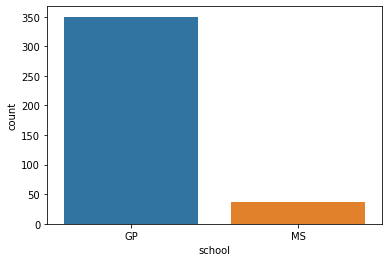

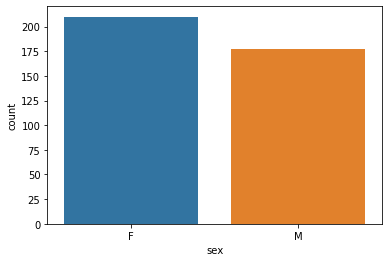

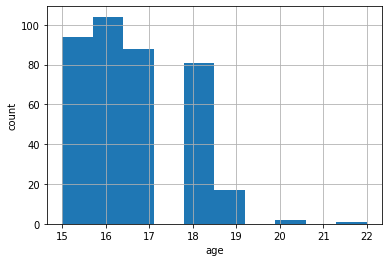

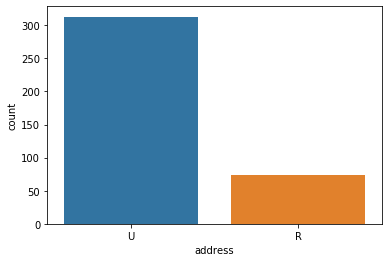

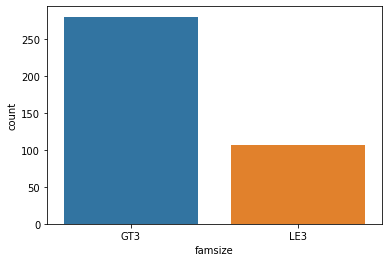

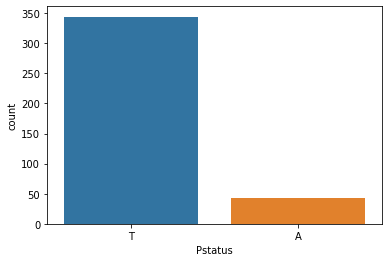

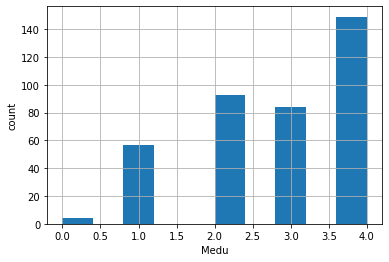

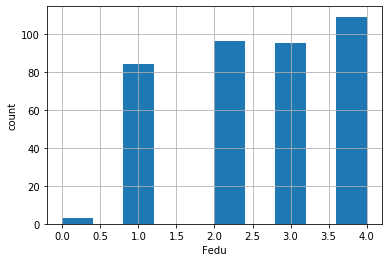

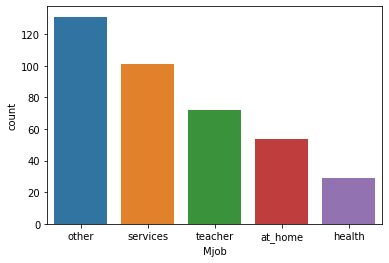

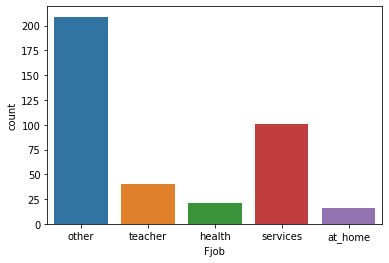

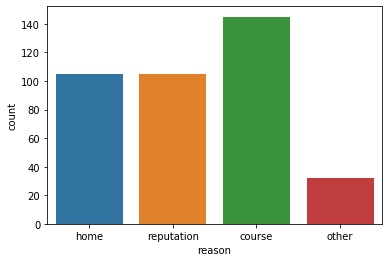

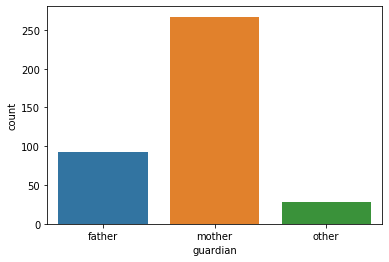

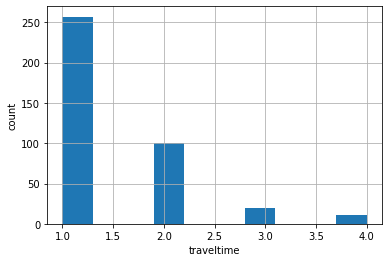

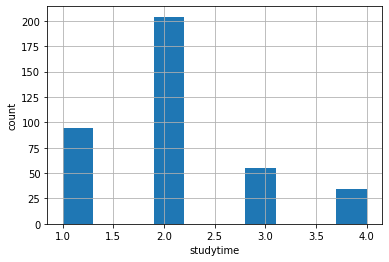

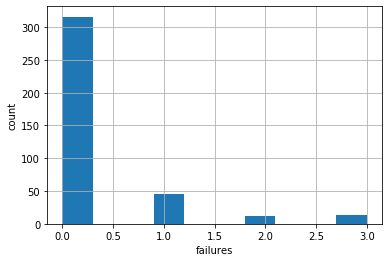

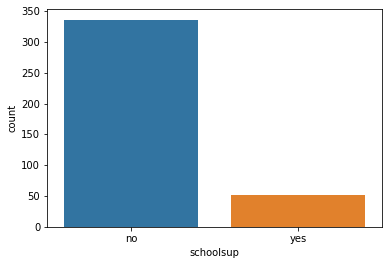

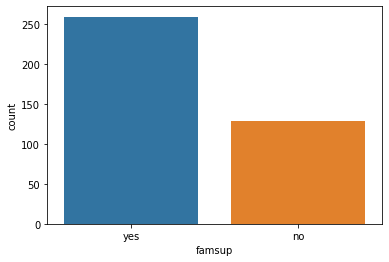

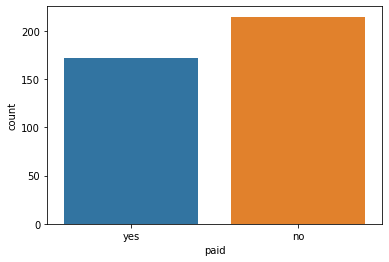

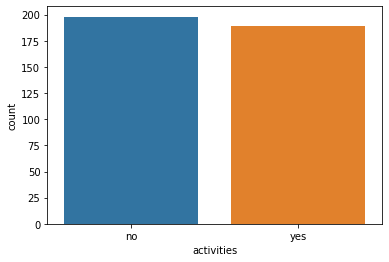

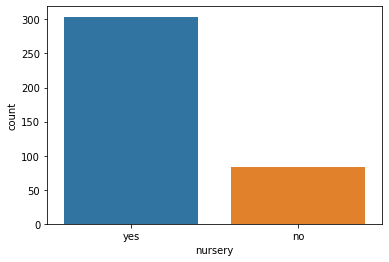

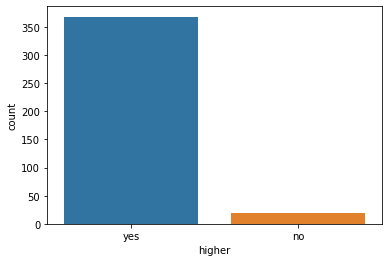

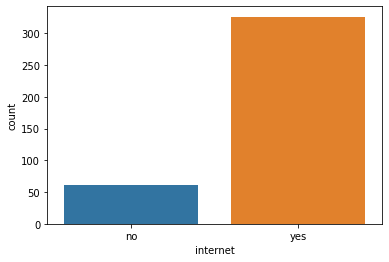

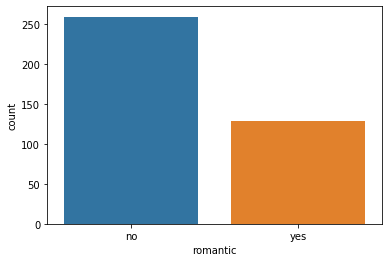

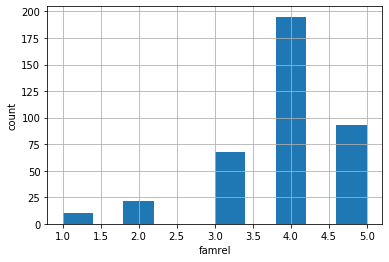

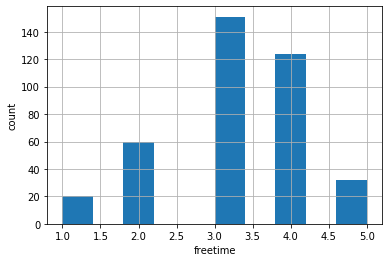

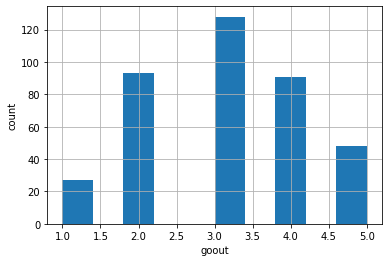

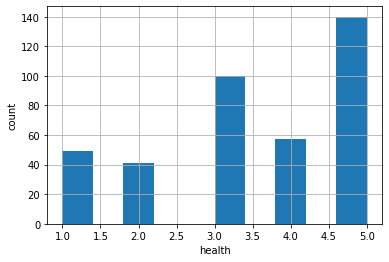

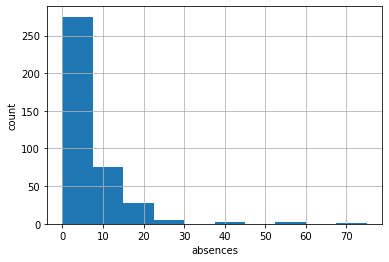

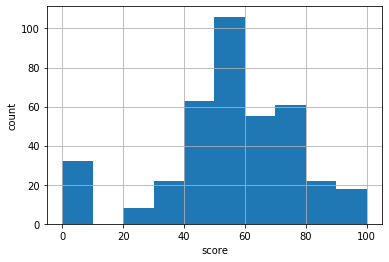

In [22]:
for col in stud.columns:
    fig, ax = plt.subplots()
    if stud[col].dtypes == np.dtype('O'):
        sns.countplot(stud[col], ax=ax)
        plt.show()
    else:
        stud[col].hist(ax = ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()

## Часть 3. Корреляционный анализ

 #### Всего в датасете 12 числовых полей, поддающихся корреляцилонному анализу:
 1. age
 6. Medu
 7. Fedu
 12. traveltime
 13. studytime
 14. failures
 24. famrel
 25. freetime
 26. goout
 27. health
 28. absences
 29. score

Исключим из анализа поностью коррелирующие друг с другом поля, а также поля, оказыывающее самое слабое влияние на поле *score*:

In [23]:
stud.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.00,-0.16,-0.10,0.08,-0.07,0.16,0.08,-0.06,0.13,-0.07,0.19,-0.13
Medu,-0.16,1.00,0.65,-0.09,0.09,-0.21,-0.08,-0.03,0.06,-0.01,0.09,0.16
Fedu,-0.10,0.65,1.00,-0.10,-0.01,-0.25,-0.07,-0.10,0.05,0.05,0.03,0.09
traveltime,0.08,-0.09,-0.10,1.00,-0.05,0.09,-0.10,0.01,0.07,-0.06,-0.04,-0.03
studytime,-0.07,0.09,-0.01,-0.05,1.00,-0.18,-0.05,-0.16,-0.06,-0.16,-0.08,0.08
failures,0.16,-0.21,-0.25,0.09,-0.18,1.00,-0.02,0.10,0.11,0.10,0.04,-0.31
famrel,0.08,-0.08,-0.07,-0.10,-0.05,-0.02,1.00,0.16,0.05,0.11,-0.04,0.05
freetime,-0.06,-0.03,-0.10,0.01,-0.16,0.10,0.16,1.00,0.23,0.02,-0.11,0.09
goout,0.13,0.06,0.05,0.07,-0.06,0.11,0.05,0.23,1.00,0.03,0.06,-0.12
health,-0.07,-0.01,0.05,-0.06,-0.16,0.10,0.11,0.02,0.03,1.00,0.01,-0.08


Полей, в существенной степени коррелирующих друг с другом нет. <br>
Ранжируем переменные по степени влияния на поле *score*:

In [24]:
stud.corr()['score'].sort_values(ascending = False)

score         1.00
Medu          0.16
freetime      0.09
Fedu          0.09
studytime     0.08
famrel        0.05
absences      0.01
traveltime   -0.03
health       -0.08
goout        -0.12
age          -0.13
failures     -0.31
Name: score, dtype: float64

Наибольшая по модулю корреляция поля score существует с полем *failures* (-31%), заметно меньше с полями:
- *Medu*, 16%
- *age*, -13%
- *goout*, -12%. <br><br>
Поля *freetime, Fedu, studytime, health, famrel* слабо коррелированны (от 5 до 10 процентов по модулю).<br>
Коэффициент корреляции полей *famrel, absences, traveltime* менее 5% - исключаем их из анализа. 

## Часть 4. Анализ номинативных перемнных

 #### Всего в датасете 17 номинативных полей:
 
 1.   school 
 1.   sex 
 3.   address 
 4.   famsize
 5.   Pstatus 
 8.   Mjob 
 9.   Fjob
 10.  reason
 11.  guardian
 15.  schoolsup
 16.  famsup
 17.  paid
 18.  activities
 19.  nursery
 21.  higher
 22.  internet
 23.  romantic


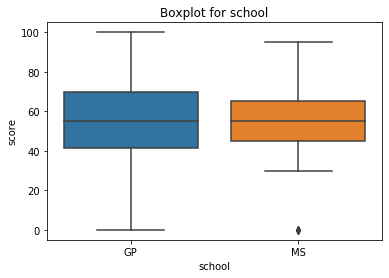

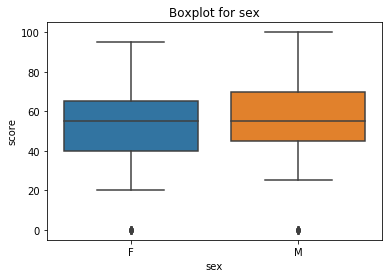

Найдены статистически значимые различия для колонки sex


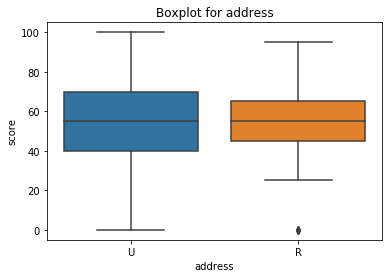

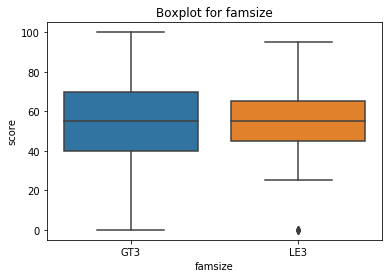

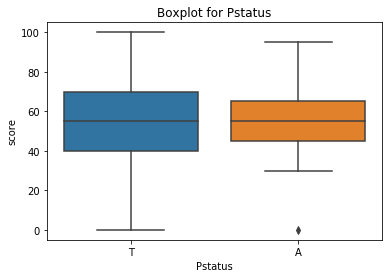

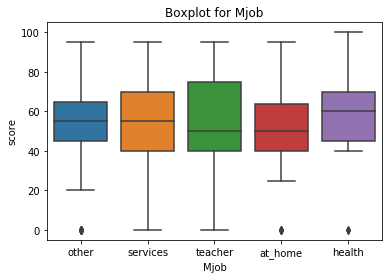

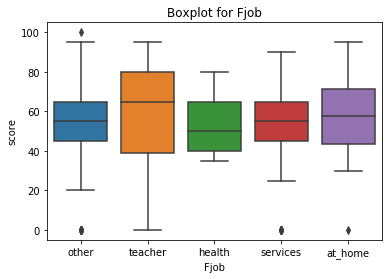

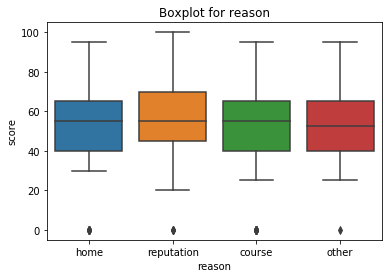

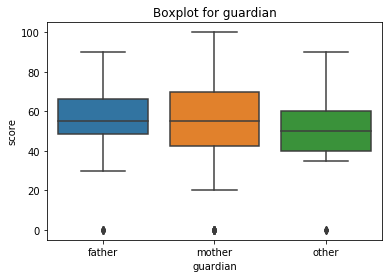

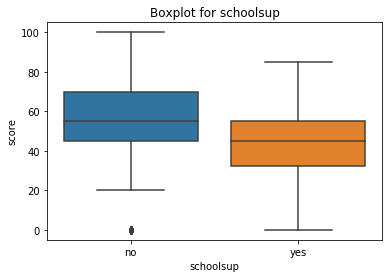

Найдены статистически значимые различия для колонки schoolsup


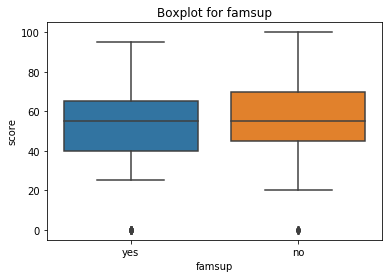

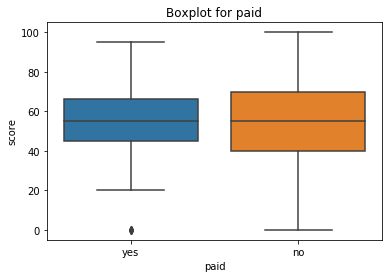

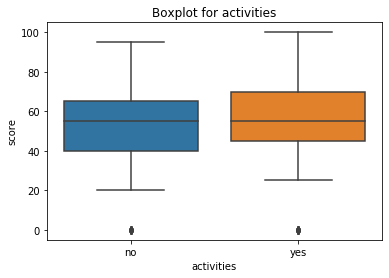

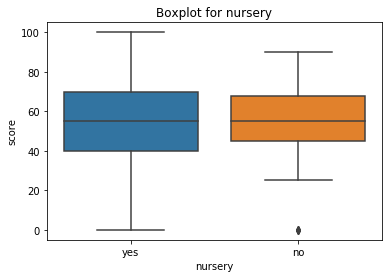

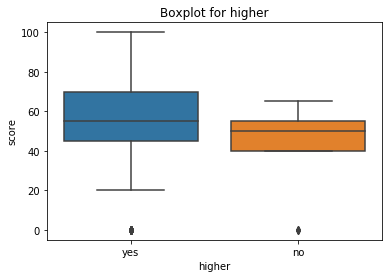

Найдены статистически значимые различия для колонки higher


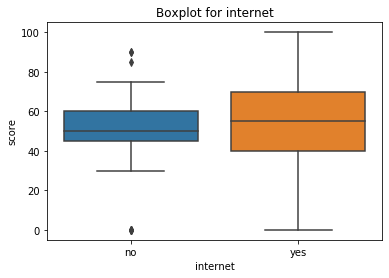

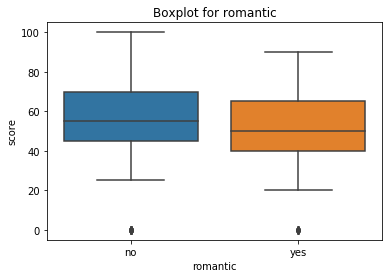

In [25]:
nondigit = 'school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic'.split(',')
for col in nondigit: get_stat(col)

По итогам теста Стьюдента определились три поля, влияющие на поле <i>score: sex, schoolsup, higher

## По итогам анализа, в модель включаем 3 номинативных переменных и 10 числовых, в наибольшей степени коррелирующие с итоговым полем <i>score:

In [26]:
stud_for_model = stud.loc[:, ['score','sex', 'higher', 'schoolsup', 'failures','Medu','Fedu','age','goout','freetime', 'studytime', 'health', 'famrel']]
stud_for_model.head(50)

,score,sex,higher,schoolsup,failures,Medu,Fedu,age,goout,freetime,studytime,health,famrel
4,50.00,F,yes,no,0.00,3.00,3.00,16,2.00,3.00,2.00,5.00,4.00
5,75.00,M,yes,no,0.00,4.00,3.00,16,2.00,4.00,2.00,5.00,5.00
7,30.00,F,yes,yes,0.00,4.00,4.00,17,4.00,1.00,2.00,1.00,4.00
10,45.00,F,yes,no,0.00,4.00,4.00,15,3.00,3.00,2.00,2.00,3.00
14,80.00,M,yes,no,0.00,2.00,2.00,15,2.00,5.00,3.00,3.00,4.00
16,70.00,F,yes,no,0.00,4.00,4.00,16,3.00,2.00,3.00,2.00,3.00
23,60.00,M,yes,no,0.00,2.00,2.00,16,4.00,4.00,2.00,5.00,5.00
24,40.00,F,yes,yes,0.00,2.00,4.00,15,2.00,3.00,3.00,5.00,4.00
39,65.00,F,yes,yes,0.00,2.00,2.00,15,1.00,3.00,1.00,2.00,4.00
45,30.00,F,yes,yes,0.00,4.00,3.00,15,2.00,2.00,2.00,5.00,5.00
